In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


📍期望時間：5/10前完成
📍需求功能：我們想要做的是一個可以預測共享單車進出量的模型，做為後面貨車再配送路徑規劃的輸入。我們現在有做出一個模型但正確率只有0.49找不到問題 目前是用LSTM作為模型基底 希望可以協助優化模型或是若有其他準確率更高的預測方法也可以

📍input 是每小時的共享單車使用量，有進站量出站量；從capital bikeshare官網下載每台單車使用狀況的紀錄再整理的資料，如果某個站點那小時裡沒有資料就會補零。

資料裡面有start_station 和end_station 各自去count 一個小時內的量，再用進量減出量的淨值去標準化（不過目前是只有先以一個站點來算）

📍output 是各個站點的單車淨需求量（進站量減出站量）

In [2]:
#下載檔案(不包含Weather)
import pandas as pd
from glob import glob
from datetime import datetime
import random
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
%matplotlib inline
years = ["2018", "2019", "2020", "2021"]
df = pd.concat((pd.read_csv(f'/content/drive/My Drive/專題研究💪/sharingbike/{y}_capitalbikeshare-tripdata.csv') for y in years),ignore_index=True,axis=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/concat.py:348: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  objs = list(objs)


# EDA

In [3]:
day = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [4]:
df["weekday"] = df['started_date'].apply(lambda x: pd.Timestamp(x).dayofweek)
df["is_weekend"] = df["weekday"].apply(lambda x : int(4<x))
df["weekday"] = df["weekday"].apply(lambda x: day[x])
df["Member type"] = df["Member type"].apply(lambda x : x.lower())

In [5]:
"""
Duration : 騎乘時長
Start station number : 借車站號碼
Start station : 借車站名
End station number : 還車站號碼
End station : 還車站名
Member type : 會員種類
started_date : 借車日期
started_time : 借車時間
started_at :借車時間日期
end_date : 還車日期
end_time : 還車時間
end_at :還車時間日期
period : 時段
month : 月份
year : 年分
season : 季節
weekday : 星期幾
is_weenkend : 是否為周末
"""
df.head()

,Duration,Start station number,Start station,End station number,End station,Member type,started_date,started_time,end_date,end_time,period,month,year,season,started_at,end_at,weekday,is_weekend
0,552.0,31104,Adams Mill & Columbia Rd NW,31400,Georgia & New Hampshire Ave NW,member,2018-01-01,00:05:06,2018-01-01,00:14:18,Early morning,1,2018,Spring,2018-01-01 00:05:06,2018-01-01 00:14:18,monday,0
1,1282.0,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,casual,2018-01-01,00:14:30,2018-01-01,00:35:53,Early morning,1,2018,Spring,2018-01-01 00:14:30,2018-01-01 00:35:53,monday,0
2,1265.0,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,casual,2018-01-01,00:14:53,2018-01-01,00:35:58,Early morning,1,2018,Spring,2018-01-01 00:14:53,2018-01-01 00:35:58,monday,0
3,578.0,31406,14th & Upshur St NW,31103,16th & Harvard St NW,casual,2018-01-01,00:15:31,2018-01-01,00:25:09,Early morning,1,2018,Spring,2018-01-01 00:15:31,2018-01-01 00:25:09,monday,0
4,372.0,31618,4th & East Capitol St NE,31619,Lincoln Park / 13th & East Capitol St NE,member,2018-01-01,00:18:02,2018-01-01,00:24:15,Early morning,1,2018,Spring,2018-01-01 00:18:02,2018-01-01 00:24:15,monday,0


# 會員種類分析

In [6]:
def weekday_sorter(column):
    """Sort by weekday"""
    day = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    correspondence = {weekday: order for order, weekday in enumerate(day)}
    return column.map(correspondence)

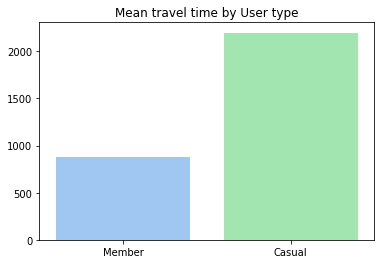

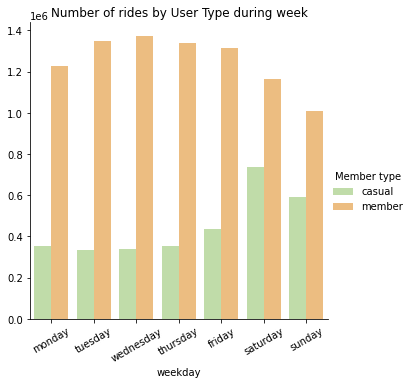

In [7]:
mean_riding_time_member = df[df["Member type"]=="member"]["Duration"].sum()/len(df[df["Member type"]=="member"]["Duration"])
mean_riding_time_casual = df[df["Member type"]=="casual"]["Duration"].sum()/len(df[df["Member type"]=="casual"]["Duration"])
plt.style.use('seaborn-pastel')
fig = plt.figure(figsize=(6,4))

ax1 = fig.add_subplot(111)
sns.barplot(x=["Member","Casual"], y=[mean_riding_time_member, mean_riding_time_casual])
ax1.set_title("Mean travel time by User type")



week_day_of_memeber = df.groupby(['weekday',"Member type"],as_index=False).size()
week_day_of_memeber = week_day_of_memeber.sort_values(by='weekday', key=weekday_sorter)

g = sns.catplot(x = 'weekday', y='size', 
               hue = 'Member type',data=week_day_of_memeber, kind='bar',palette='Spectral_r').set(
                   title='Number of rides by User Type during week',
                   ylabel=None)

g.set_xticklabels(rotation=30)


plt.show()

從資料中可以看出:
休閒的用戶騎乘時間比會員用戶更長，而會員騎乘的次數遠高於休閒的次數

In [8]:
def distribution(data, title, x_label, y_label):
    fig = plt.figure(figsize=(8,5))

    ax1 = fig.add_subplot(221)
    
    plt.style.use('seaborn-pastel')
    density = sns.barplot(x=data.index, y=data.values)
    title = plt.title(title, fontdict={'fontsize': 20})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plt.show()

# 騎乘人數與時間分析

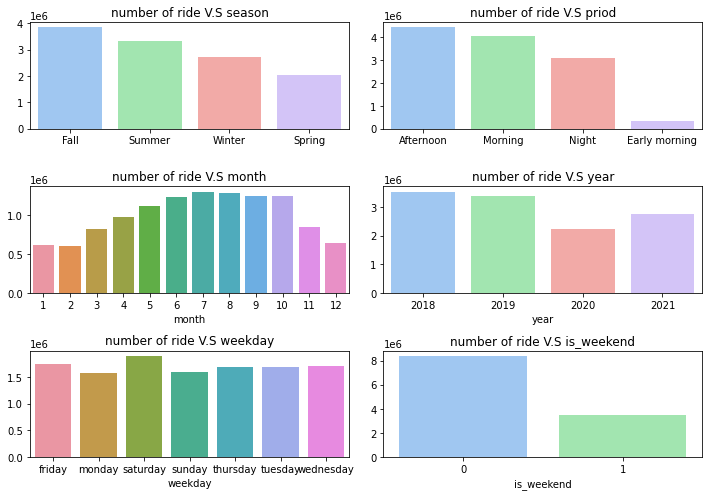

In [9]:
fig = plt.figure(figsize=(10,7))

plt.style.use('seaborn-pastel')

season_data = df["season"].value_counts()

ax1 = fig.add_subplot(321)
sns.barplot(x=season_data.index, y=season_data.values)
ax1.set_title("number of ride V.S season")

period_data = df["period"].value_counts()

ax2 = fig.add_subplot(322)
sns.barplot(x=period_data.index, y=period_data.values)
ax2.set_title("number of ride V.S priod")

month_data = df.groupby(by='month').size()

ax3 = fig.add_subplot(323)
sns.barplot(x=month_data.index, y=month_data.values)
ax3.set_title("number of ride V.S month")

year_data = df.groupby(by='year').size()

ax4 = fig.add_subplot(324)
sns.barplot(x=year_data.index, y=year_data.values)
ax4.set_title("number of ride V.S year")

week_data = df.groupby(by='weekday').size()

ax5 = fig.add_subplot(325)
sns.barplot(x=week_data.index, y=week_data.values)
ax5.set_title("number of ride V.S weekday")

weekend_data = df.groupby(by='is_weekend').size()

ax6 = fig.add_subplot(326)
sns.barplot(x=weekend_data.index, y=weekend_data.values)
ax6.set_title("number of ride V.S is_weekend")

fig.tight_layout()
plt.show()
# fig.savefig('/content/drive/MyDrive/專題研究💪/sharingbike/plot.png')

$* Season$

從資料顯示秋天和夏天騎車的人數較多，春天最少，季節可能為重要的feature

$* Period$

下午和早晨的騎車人數較多，晚上較少，凌晨則是非常少，此為重要的Feature

$* Month$

1-8月有逐漸上升的趨勢，但無特定規律，可能不是重要的Feature

$* Year$

2022騎車人數銳減，可能因為疫情影響，後續會以年分作為EDA的分類

# 各年份的騎乘人數與時間分析

In [10]:
import numpy as np

In [11]:
def colors_from_values(values, palette_name):
  values = sorted(values)
  palette = sns.color_palette(palette_name, len(values))
  color_dict ={}
  for v, c in zip(values, palette):
    color_dict[v]= c
  return color_dict

In [12]:
def year_EDA(year):

  df_year = df.query(f'year=={int(year)}')
  fig = plt.figure(figsize=(12,9))

  plt.style.use('seaborn-pastel')

  season_data = df_year["season"].value_counts()

  ax1 = fig.add_subplot(221)
  sns.barplot(x=season_data.index, y=season_data.values, palette=colors_from_values(season_data.index, "terrain"))
  ax1.set_title("number of ride V.S season")

  period_data = df_year["period"].value_counts()

  ax2 = fig.add_subplot(222)
  sns.barplot(x=period_data.index, y=period_data.values, palette=colors_from_values(period_data.index, "plasma"))
  ax2.set_title("number of ride V.S priod")

  month_data = df_year.groupby(by='month').size()

  ax3 = fig.add_subplot(223)
  sns.barplot(x=month_data.index, y=month_data.values)
  ax3.set_title("number of ride V.S month")

  week_data = df_year.groupby(by='weekday').size().sort_index(key=weekday_sorter)

  ax4 = fig.add_subplot(224)
  sns.barplot(x=week_data.index, y=week_data.values)
  ax4.set_title("number of ride V.S weekday")
  ax4.set_xticklabels(ax4.get_xticklabels(),rotation=30)

  plt.tight_layout()
  plt.show()

==============================2018 analysis==============================


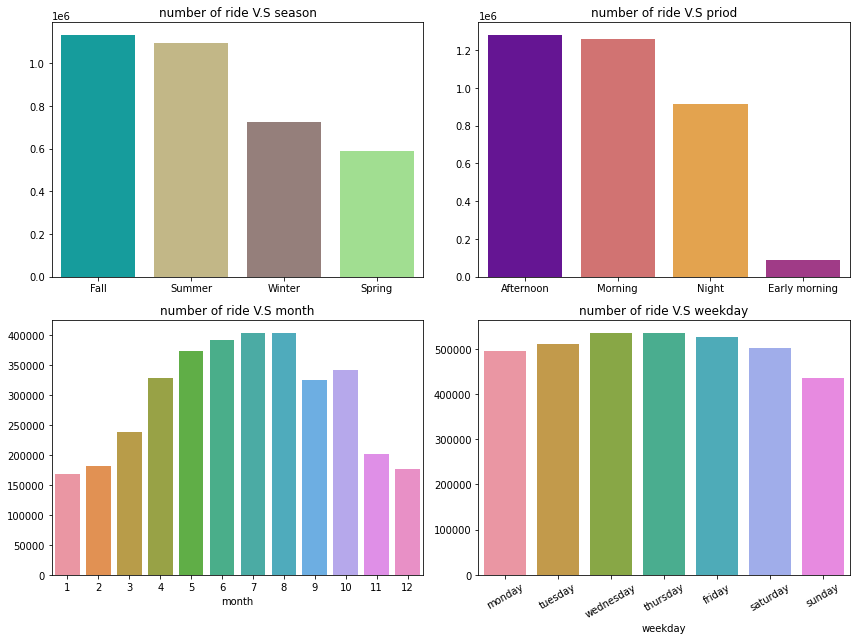

In [13]:
print("==============================2018 analysis==============================")
year_EDA(2018)

==============================2019 analysis==============================


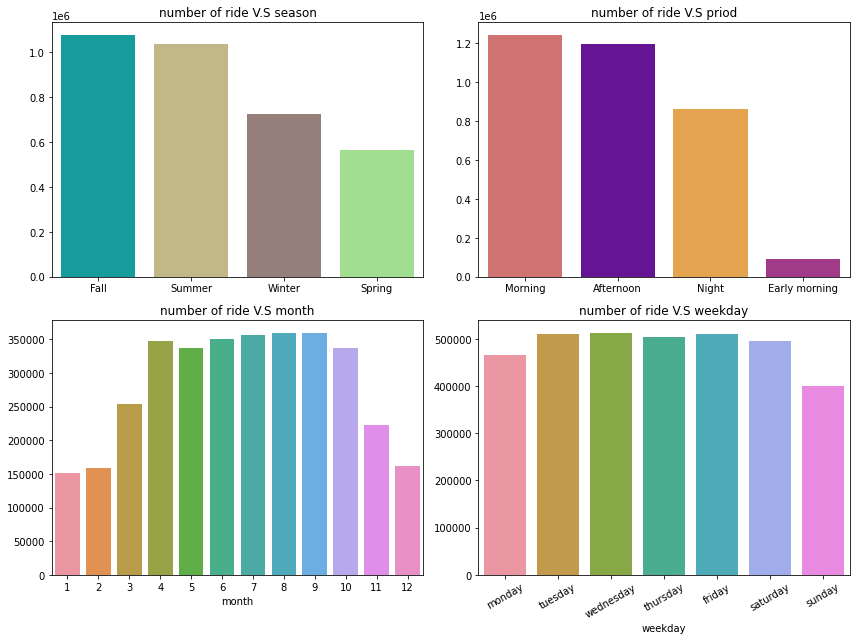

In [14]:
print("==============================2019 analysis==============================")
year_EDA(2019)

==============================2020 analysis==============================


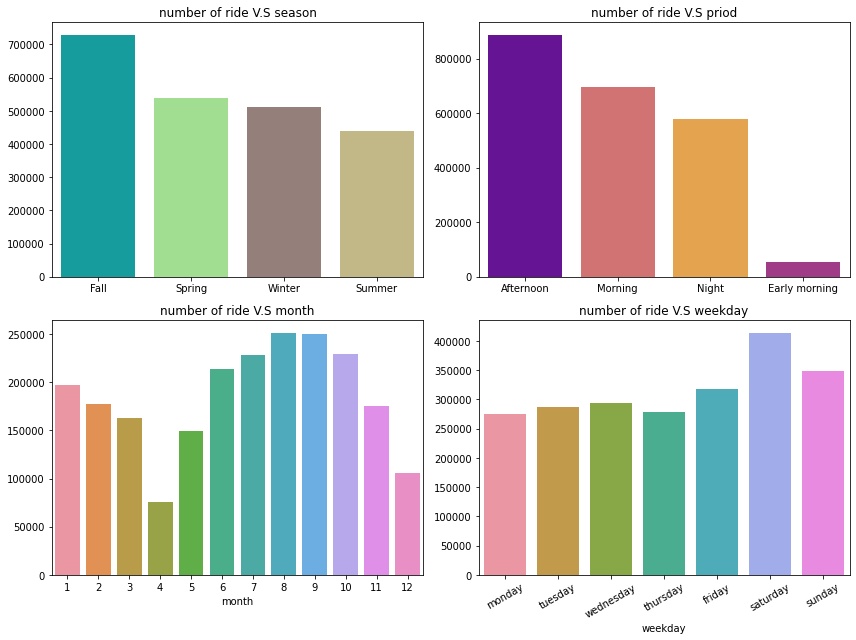

In [15]:
print("==============================2020 analysis==============================")
year_EDA(2020)

==============================2021 analysis==============================


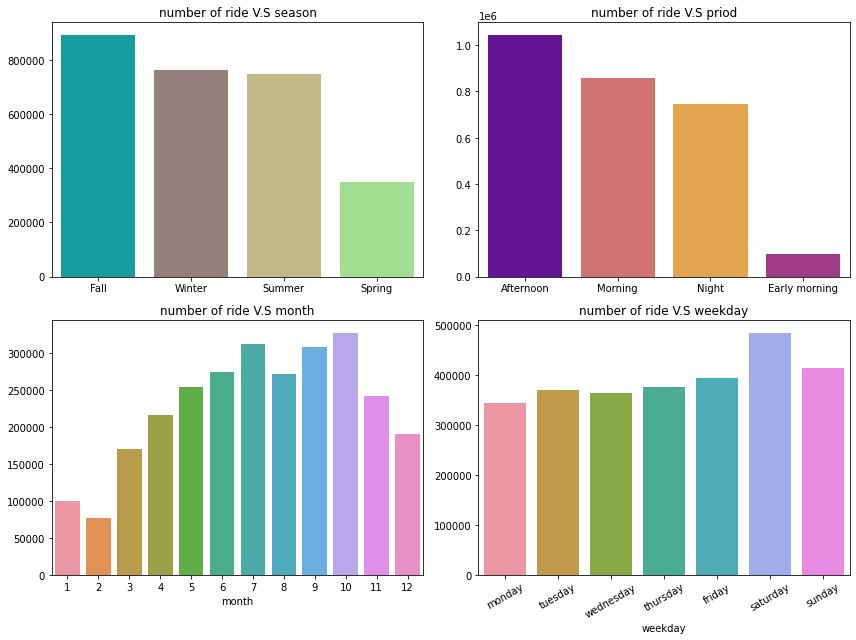

In [16]:
print("==============================2021 analysis==============================")
year_EDA(2021)

**總體來看**

季節，時段，和月份都騎乘人數成一定的相關

每一年的秋天皆為騎乘人數最多的時候

早上和下午的騎乘人數較多，凌晨最少

除了2020年以外，從3月起騎乘人數都會開始呈現正趨勢，直到7,8月達到高峰


## 站點分析

In [17]:
start_station_list = list(df['Start station'].unique())
end_station_list = list(df["End station"].unique())
all_stations =set(start_station_list+end_station_list)

In [18]:
print(f"共有{len(all_stations)}個站點")

共有800個站點


In [19]:
start_station_cnt = df.groupby('Start station').size().sort_values(ascending=False)
end_station_cnt = df.groupby('End station').size().sort_values(ascending=False)

Columbus Circle / Union Station 作為還車或是借車的站點都是流量最大的站點

In [ ]:
print(start_station_cnt.describe())
print(end_station_cnt.describe())

## 站點車輛數預測
預測目標，單位時間內的車輛進出數量

以一小時為時間單位

In [ ]:
#除去空值
df = df.dropna()
df.isnull().sum()

Duration                0
Start station number    0
Start station           0
End station number      0
End station             0
Member type             0
started_date            0
started_time            0
end_date                0
end_time                0
period                  0
month                   0
year                    0
season                  0
started_at              0
end_at                  0
weekday                 0
is_weekend              0
dtype: int64

In [ ]:
# 租車站點
station_counts_from =pd.DataFrame(df["Start station"].value_counts())

# 還車站點
station_counts_to= pd.DataFrame(df['End station'].value_counts())

In [ ]:
station_counts_from.head()

,Start station
Columbus Circle / Union Station,160349
Lincoln Memorial,142007
4th St & Madison Dr NW,122868
Jefferson Dr & 14th St SW,121907
15th & P St NW,121888


In [ ]:
station_counts_to.head()

,End station
Columbus Circle / Union Station,171739
Lincoln Memorial,139388
15th & P St NW,130303
Jefferson Dr & 14th St SW,126061
4th St & Madison Dr NW,122195


In [ ]:
#所有車站
"""
checkins : 借車數
checkout : 還車數
total : 總借還量
"""
station_counts = pd.concat([station_counts_from, station_counts_to], axis=1)
station_counts.rename(columns={'End station':'checkouts', 'Start station':'checkins'}, inplace=True)

station_counts['total'] = station_counts['checkouts'] + station_counts['checkins']

In [ ]:
station_counts.head()

,checkins,checkouts,total
Columbus Circle / Union Station,160349.0,171739.0,332088.0
Lincoln Memorial,142007.0,139388.0,281395.0
4th St & Madison Dr NW,122868.0,122195.0,245063.0
Jefferson Dr & 14th St SW,121907.0,126061.0,247968.0
15th & P St NW,121888.0,130303.0,252191.0


In [ ]:
#從原始資料中考慮，決定使用前20流量的站點
#使用前20名流量的站點
station_counts_20 = station_counts.sort_values('total', ascending=False).head(20)
stations = list(station_counts_20.index)

In [ ]:
## 從原始資料中取出在前20 stations的資料
df_station = df[(df['Start station'].isin(stations)) | (df['End station'].isin(stations))]

In [ ]:
df_station.head(2)

,Duration,Start station number,Start station,End station number,End station,Member type,started_date,started_time,end_date,end_time,period,month,year,season,started_at,end_at,weekday,is_weekend
1,1282.0,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,casual,2018-01-01,00:14:30,2018-01-01,00:35:53,Early morning,1,2018,Spring,2018-01-01 00:14:30,2018-01-01 00:35:53,monday,0
2,1265.0,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,casual,2018-01-01,00:14:53,2018-01-01,00:35:58,Early morning,1,2018,Spring,2018-01-01 00:14:53,2018-01-01 00:35:58,monday,0


In [ ]:
## 查看資料佔比
##
total_trip_count = len(df)
top_20_count = len(df_station)
percent = round(top_20_count/total_trip_count, 3) * 100
print("Of the {} total trips, {} involve one of our 26 stations. That's {}%".format(total_trip_count,top_20_count, percent))

Of the 11484145 total trips, 3586036 involve one of our 26 stations. That's 31.2%


In [ ]:
# 轉換成datetime格式
df_station['started_at'] = pd.to_datetime(df_station['started_at'])
df_station['end_at'] = pd.to_datetime(df_station['end_at'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#取出給要使用的欄位
df_model = df_station[['Start station', 'started_at', 'End station', 'end_at', "is_weekend" ,'Member type', 'weekday','period', 'year', 'month']]
#把started time 設為 index
df_model.index = df_model["started_at"]
df_model.drop('started_at', axis=1, inplace=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3586036 entries, 2018-01-01 00:14:30 to 2021-12-06 14:17:00
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Start station  object        
 1   End station    object        
 2   end_at         datetime64[ns]
 3   is_weekend     int64         
 4   Member type    object        
 5   weekday        object        
 6   period         object        
 7   year           int64         
 8   month          int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 273.6+ MB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_model.head()

,Start station,End station,end_at,is_weekend,Member type,weekday,period,year,month
started_at,,,,,,,,,
2018-01-01 00:14:30,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:53,0,casual,monday,Early morning,2018,1
2018-01-01 00:14:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:58,0,casual,monday,Early morning,2018,1
2018-01-01 00:23:41,Maine Ave & 9th St SW,4th & M St SW,2018-01-01 00:28:35,0,member,monday,Early morning,2018,1
2018-01-01 00:37:44,California St & Florida Ave NW,14th & Rhode Island Ave NW,2018-01-01 00:44:31,0,member,monday,Early morning,2018,1
2018-01-01 00:39:24,18th St & Wyoming Ave NW,15th & P St NW,2018-01-01 00:48:54,0,member,monday,Early morning,2018,1


In [ ]:
## Add the hour of day (0-23)
df_model['hour'] = df_model.index.map(lambda x:str(x)[11:13])

df_model.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Start station,End station,end_at,is_weekend,Member type,weekday,period,year,month,hour
started_at,,,,,,,,,,
2018-01-01 00:14:30,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:53,0,casual,monday,Early morning,2018,1,00
2018-01-01 00:14:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:58,0,casual,monday,Early morning,2018,1,00


In [ ]:
station_counts.head()

,checkins,checkouts,total
Columbus Circle / Union Station,160349.0,171739.0,332088.0
Lincoln Memorial,142007.0,139388.0,281395.0
4th St & Madison Dr NW,122868.0,122195.0,245063.0
Jefferson Dr & 14th St SW,121907.0,126061.0,247968.0
15th & P St NW,121888.0,130303.0,252191.0


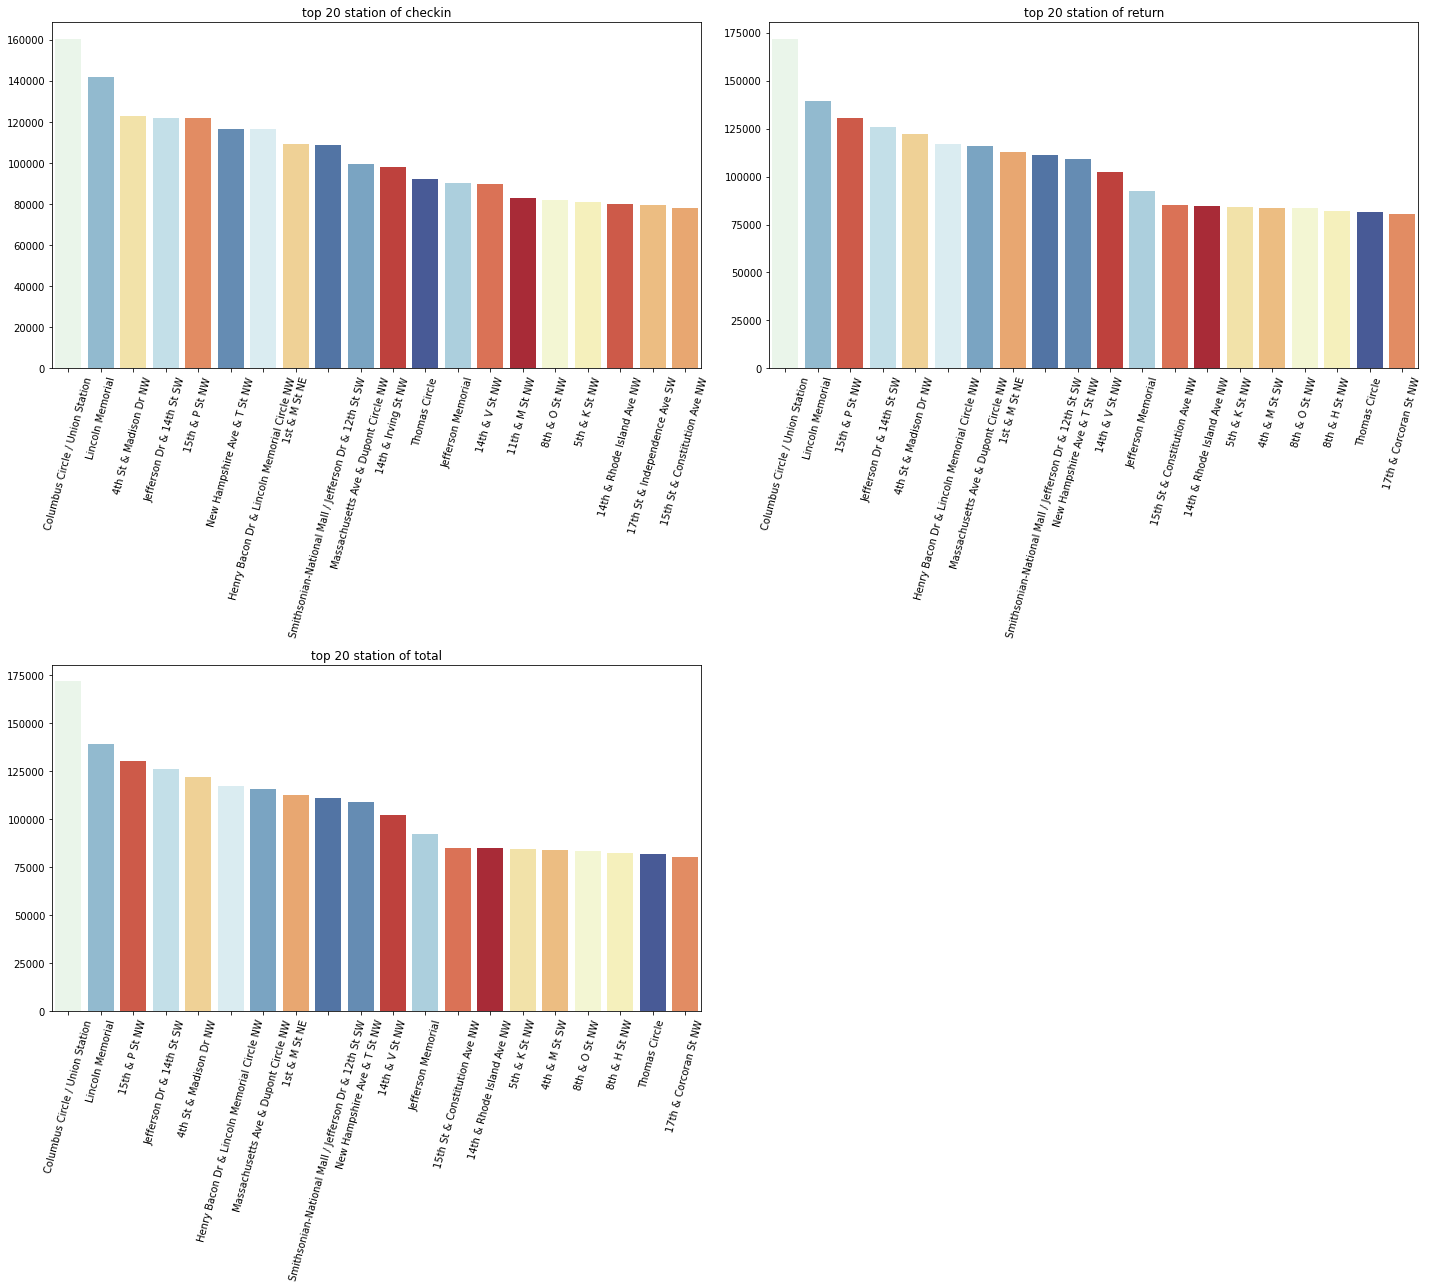

In [ ]:
fig = plt.figure(figsize=(20,18))

top20_start_station_cnt = station_counts["checkins"].sort_values(ascending=False)[:20]
ax1 = fig.add_subplot(221)
sns.barplot(x=top20_start_station_cnt.index, y=top20_start_station_cnt.values,
            palette=colors_from_values(top20_start_station_cnt.index, "RdYlBu"))
ax1.set_title("top 20 station of checkin")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=75)

top20_end_station_cnt = station_counts["checkouts"].sort_values(ascending=False)[:20]

ax2 = fig.add_subplot(222)
sns.barplot(x=top20_end_station_cnt.index, y=top20_end_station_cnt.values,
            palette=colors_from_values(top20_end_station_cnt.index, "RdYlBu"))

ax2.set_title("top 20 station of return")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=75)


top20_total_station_cnt = station_counts["total"].sort_values(ascending=False)[:20]

ax3 = fig.add_subplot(223)
sns.barplot(x=top20_end_station_cnt.index, y=top20_end_station_cnt.values,
            palette=colors_from_values(top20_end_station_cnt.index, "RdYlBu"))

ax3.set_title("top 20 station of total")
ax3.set_xticklabels(ax2.get_xticklabels(),rotation=75)

plt.tight_layout()
plt.show()

## 以上的資料可以做top 20 站點EDA(optional)

#借車預測

In [ ]:
# end_st = df_model[df_model['End station'].isin(stations)]
# end_st.to_csv('/content/drive/MyDrive/專題研究💪/sharingbike/ReturnTop20.csv', index=True)

In [ ]:
# 從df_model取出借車 top 20的站點
start_st = df_model[df_model['Start station'].isin(stations)]
start_st.head()

,Start station,End station,end_at,is_weekend,Member type,weekday,period,year,month,hour
started_at,,,,,,,,,,
2018-01-01 00:14:30,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:53,0,casual,monday,Early morning,2018,1,00
2018-01-01 00:14:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:58,0,casual,monday,Early morning,2018,1,00
2018-01-01 00:42:08,14th & V St NW,11th & O St NW,2018-01-01 00:49:25,0,member,monday,Early morning,2018,1,00
2018-01-01 01:03:23,14th & V St NW,18th St & Wyoming Ave NW,2018-01-01 01:09:47,0,member,monday,Early morning,2018,1,01
2018-01-01 01:13:43,Columbus Circle / Union Station,4th & East Capitol St NE,2018-01-01 01:18:25,0,member,monday,Early morning,2018,1,01


In [ ]:
#根據時間(小時為單位)來分群
start_st['groupby_col'] = start_st.index.map(lambda x:str(x)[:13])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
start_st.head(3)

,Start station,End station,end_at,is_weekend,Member type,weekday,period,year,month,hour,groupby_col
started_at,,,,,,,,,,,
2018-01-01 00:14:30,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:53,0,casual,monday,Early morning,2018,1,00,2018-01-01 00
2018-01-01 00:14:53,15th St & Constitution Ave NW,15th St & Constitution Ave NW,2018-01-01 00:35:58,0,casual,monday,Early morning,2018,1,00,2018-01-01 00
2018-01-01 00:42:08,14th & V St NW,11th & O St NW,2018-01-01 00:49:25,0,member,monday,Early morning,2018,1,00,2018-01-01 00


In [ ]:
# 每小時借車量
start_st_model =pd.DataFrame(start_st.groupby(['Start station', 'groupby_col'])['hour'].count())

In [ ]:
start_st_model.head()

hour
Start station  groupby_col        
11th & M St NW 2018-01-01 01     1
               2018-01-01 07     1
               2018-01-01 09     1
               2018-01-01 10     1
               2018-01-01 11     4

In [ ]:
# Rename the 'hour' to 'from_cnt'
# Make the 'grouby_col' the index

start_st_model.rename(columns={'hour':'from_cnt'}, inplace=True)
start_st_model.reset_index(inplace=True)
start_st_model.index = start_st_model['groupby_col']

In [ ]:
start_st_model.head()

,Start station,groupby_col,from_cnt
groupby_col,,,
2018-01-01 01,11th & M St NW,2018-01-01 01,1
2018-01-01 07,11th & M St NW,2018-01-01 07,1
2018-01-01 09,11th & M St NW,2018-01-01 09,1
2018-01-01 10,11th & M St NW,2018-01-01 10,1
2018-01-01 11,11th & M St NW,2018-01-01 11,4


In [ ]:
start_st_model['year'] = start_st_model.index.map(lambda x:str(x)[:4])
start_st_model['month'] = start_st_model.index.map(lambda x:str(x)[5:7])
start_st_model['hour'] = start_st_model.index.map(lambda x:str(x)[11:13])

In [ ]:
start_st_model['groupby_col'] = pd.to_datetime(start_st_model['groupby_col'])
start_st_model.index = start_st_model['groupby_col']

In [ ]:
start_st_model.head(3)

,Start station,groupby_col,from_cnt,year,month,hour
groupby_col,,,,,,
2018-01-01 01:00:00,11th & M St NW,2018-01-01 01:00:00,1,2018,01,01
2018-01-01 07:00:00,11th & M St NW,2018-01-01 07:00:00,1,2018,01,07
2018-01-01 09:00:00,11th & M St NW,2018-01-01 09:00:00,1,2018,01,09


In [ ]:
start_st_model['day'] = start_st_model.index.day_name()
start_st_model.drop('groupby_col', axis=1, inplace=True)

In [ ]:
start_st_model.head(3)

,Start station,from_cnt,year,month,hour,day
groupby_col,,,,,,
2018-01-01 01:00:00,11th & M St NW,1,2018,01,01,Monday
2018-01-01 07:00:00,11th & M St NW,1,2018,01,07,Monday
2018-01-01 09:00:00,11th & M St NW,1,2018,01,09,Monday


In [ ]:
start_st_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 431654 entries, 2018-01-01 01:00:00 to 2021-12-31 23:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Start station  431654 non-null  object
 1   from_cnt       431654 non-null  int64 
 2   year           431654 non-null  object
 3   month          431654 non-null  object
 4   hour           431654 non-null  object
 5   day            431654 non-null  object
dtypes: int64(1), object(5)
memory usage: 23.1+ MB


In [ ]:
## 'Start station', 'year', 'month', 'day', 'hour' columns to be converted to dummies
import pandas as pd
starts = pd.get_dummies(data=start_st_model, columns=['Start station', 'year', 'month', 'day', 'hour'])

In [ ]:
starts.head(2)

,from_cnt,Start station_11th & M St NW,Start station_14th & Irving St NW,Start station_14th & Rhode Island Ave NW,Start station_14th & V St NW,Start station_15th & P St NW,Start station_15th St & Constitution Ave NW,Start station_1st & M St NE,Start station_4th & M St SW,Start station_4th St & Madison Dr NW,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
groupby_col,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-01-01 07:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


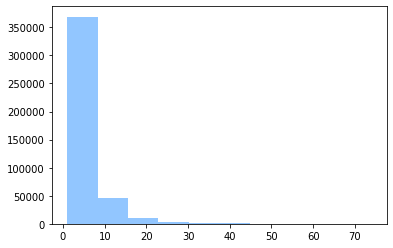

In [ ]:
plt.hist(starts['from_cnt'])
plt.show()

In [ ]:
print(starts['from_cnt'].skew())

3.0464655987289926


資料偏度為3.04，為right skewed類型

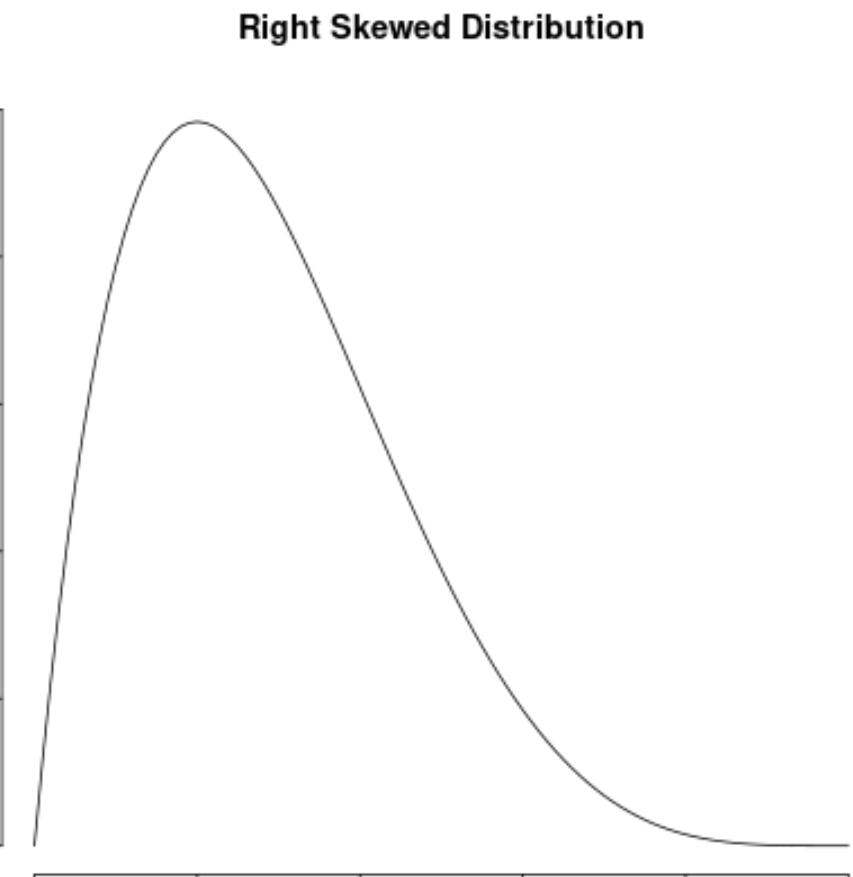

In [ ]:
import numpy as np

In [ ]:
## 資料偏度轉換

log_trans = np.log(starts['from_cnt']).skew()
sqrt_trans = (starts['from_cnt'] ** .5).skew()
cube_trans = (starts['from_cnt'] ** (1/3)).skew()

print('Log Transformation:', log_trans)
print('Square Root Transformation:', sqrt_trans)
print('Cube Root Transformation', cube_trans)

Log Transformation: 0.25764097940203534
Square Root Transformation: 1.3169649195714432
Cube Root Transformation 0.9043287508821031


在訓練時我們會希望資料盡量符合normal distrubution(skew靠近0)
上面三種轉換法中，log最靠近0，因此選擇將cnt以log轉換


In [ ]:
## Transform the check-out values

starts['from_cnt(log)'] = np.log(starts['from_cnt'])

In [ ]:
starts.head()

,from_cnt,Start station_11th & M St NW,Start station_14th & Irving St NW,Start station_14th & Rhode Island Ave NW,Start station_14th & V St NW,Start station_15th & P St NW,Start station_15th St & Constitution Ave NW,Start station_1st & M St NE,Start station_4th & M St SW,Start station_4th St & Madison Dr NW,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,from_cnt(log)
groupby_col,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2018-01-01 07:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2018-01-01 09:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2018-01-01 10:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2018-01-01 11:00:00,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.386294


In [ ]:
# 切割訓練和測試集
training = starts[:333739]
testing = starts[333739:]

In [ ]:
y_train = training['from_cnt(log)']
x_train = training.drop(['from_cnt', 'from_cnt(log)'], axis=1)

y_test = testing['from_cnt(log)']
x_test = testing.drop(['from_cnt', 'from_cnt(log)'], axis=1)

In [ ]:
y_test[y_test.isnull()]

Series([], Name: from_cnt(log), dtype: float64)

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=15, n_jobs=-1)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)

In [ ]:
## Random Forset metrics

#np.e從log還原
# Mean Squared Error
rf_mse = mean_squared_error(np.e ** y_test, np.e ** rf_preds)

# r2 score
rf_r2 = r2_score(np.e ** y_test, np.e ** rf_preds)

# Mean Absolute Error
rf_mean_ae = mean_absolute_error(np.e ** y_test, np.e ** rf_preds)

# Median Absolute Error
rf_median_ae = median_absolute_error(np.e ** y_test, np.e ** rf_preds)